In [1]:
# default_exp calib

This contains scripts to perform camera calibration

# Import

In [2]:
# export
import numpy as np
import torch

from camera_calib_python.control_refine import CheckerRefiner
from camera_calib_python.modules import (CamSF, Heikkila97Distortion,
                                         Normalize, Rigid)
from camera_calib_python.utils import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from camera_calib_python.cb_geom import CbGeom, CpCSRGrid, FmCFPGrid
from camera_calib_python.control_refine import OpenCVCheckerRefiner
from camera_calib_python.fiducial_detect import DotVisionCheckerDLDetector
from camera_calib_python.image import File16bitImg

# Utility

In [4]:
def init_intrin(Hs, sz):
    yo, xo = (np.array(sz)-1)/2
    po_inv = np.array([[1, 0, -xo],
                       [0, 1, -yo],
                       [0, 0,   1]])
    A, b = [np.empty(0) for _ in range(2)]
    for H in Hs:
        H_bar = po_inv@H
        v1, v2 = H_bar[:,0], H_bar[:,1]
        v3, v4 = v1+v2, v1-v2
        v1, v2, v3, v4 = unitize(np.stack([v1, v2, v3, v4]))
        A = np.r_[A, np.array([v1[0]*v2[0]+v1[1]*v2[1], v3[0]*v4[0]+v3[1]*v4[1]])]
        b = np.r_[b, np.array([-v1[2]*v2[2], -v3[2]*v4[2]])]
    alpha = np.sqrt(np.dot(b,A)/np.dot(b,b))
    return np.array([[alpha,     0, xo],
                     [    0, alpha, yo],
                     [    0,     0,  1]])

In [5]:
def init_extrin(H, A):
    H_bar = np.linalg.inv(A)@H
    lambdas = np.linalg.norm(H_bar, axis=0)
    r1, r2 = [H_bar[:,idx]/lambdas[idx] for idx in range(2)]
    r3 = np.cross(r1, r2)
    R = approx_R(np.c_[r1,r2,r3])
    t = H_bar[:,2]/np.mean(lambdas[0:2])
    return R, t

# Single Calibration

This will calibrate a single camera

In [6]:
def single_calib_f(imgs, 
                   cb_geom, 
                   detector, 
                   refiner, 
                   Cam=CamSF,
                   Distortion=Heikkila97Distortion,
                   loss=torch.nn.functional.mse_loss,
                   cutoff_it=500,
                   cutoff_norm=1e-5):
    ps_f_w = cb_geom.ps_f
    
    # Get initial homographies via fiducial markers
    Hs = []
    for img in imgs:
        ps_f_p = detector(img.array_gs)
        Hs.append(homography(ps_f_w, ps_f_p))
        
    return single_calib_H(imgs, 
                          cb_geom, 
                          Hs, 
                          refiner,
                          Cam=CamSF,
                          Distortion=Distortion)

In [7]:
def single_calib_H(imgs, 
                   cb_geom, 
                   Hs,
                   refiner,
                   Cam=CamSF,
                   Distortion=Heikkila97Distortion,
                   loss=torch.nn.functional.mse_loss,
                   cutoff_it=500,
                   cutoff_norm=1e-5):
    ps_c_w = cb_geom.ps_c
    bs_c_w = cb_geom.bs_c
    
    # Get refined control points
    pss_c_p = []
    for img, H in zip(imgs, Hs):
        print(f'Refining control points for: {img.name}...')
        ps_c_p = pmm(H, ps_c_w, aug=True)
        bs_c_p = np.array([pmm(H, b_c_w, aug=True) for b_c_w in bs_c_w], np.object)
        pss_c_p.append(refiner(img.array_gs, ps_c_p, bs_c_p))

    # Update homographies with refined control points
    for idx, ps_c_p in enumerate(pss_c_p):
        Hs[idx] = homography(ps_c_w, ps_c_p)
    
    # Get initial guess for intrinsics; distortion assumed to be zero
    A = init_intrin(Hs, imgs[0].size)
    
    # Get intial guess for extrinsics
    Rs, ts = [], []
    for H in Hs:
        R, t = init_extrin(H, A)
        Rs.append(R)
        ts.append(t)
        
    # Entering torch land...
        
    # Get points for nonlinear refinement    
    ps_c_w = torch.Tensor(np.c_[ps_c_w, np.zeros(len(ps_c_w))]) # 3rd dimenion is zero for calibration boards
    pss_c_p = [torch.Tensor(ps_c_p) for ps_c_p in pss_c_p]
    
    # Intrinsic modules
    cam = Cam(torch.Tensor(A))
    distort = Distortion()
    
    # Extrinsic modules
    rigids = [Rigid(torch.Tensor(R), torch.Tensor(t)) for R,t in zip(Rs,ts)]
    
    # Get ms_w2p transformations
    if isinstance(refiner, CheckerRefiner):
        ms_w2p = [torch.nn.Sequential(rigids[idx], 
                                      Normalize(), 
                                      distort, 
                                      cam)
                  for idx, (R,t) in enumerate(zip(Rs, ts))]
    else:
        raise RuntimeError(f'Dont know how to handle: {type(refiner)}')

    pass
    
    # Do nonlinear optimization
    def _get_loss():
        return torch.sum(torch.stack([loss(ps_c_p, m_w2p(ps_c_w)) for m_w2p, ps_c_p in zip(ms_w2p, pss_c_p)]))
    
    def _get_params():
        return sum([list(m.parameters()) for m in [cam, distort]+rigids], [])
    
    print(f'Refining parameters...')
    optim = torch.optim.LBFGS(_get_params())
    params_prev = torch.cat([p.view(-1) for p in _get_params()])
    for it in range(cutoff_it):
        def _closure():
            optim.zero_grad()
            l = _get_loss()
            l.backward()
            return l
        optim.step(_closure)
        params = torch.cat([p.view(-1) for p in _get_params()])
        norm = torch.norm(params-params_prev)
        print(f' - Iteration: {it:03d} - Norm: {norm.item():10.5f} - Loss: {_get_loss().item():10.5f}')
        if norm < cutoff_norm: break
        params_prev = params
        
    return cam, distort, rigids, ms_w2p

# Test

In [8]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

In [9]:
file_model = Path('/home/justin/justinblaber/camera_calib_python/models/dot_vision_checker.pth')
detector = DotVisionCheckerDLDetector(file_model)

In [10]:
refiner = OpenCVCheckerRefiner(hw_min=3, hw_max=10, cutoff_it=5, cutoff_norm=1e-2)

In [11]:
imgs = [File16bitImg(file_img) for file_img in Path('/home/justin/Downloads/CAM_1').glob('*CAM_1*.png')]

In [12]:
cam, distort, rigids, ms_w2p = single_calib_f(imgs, cb_geom, detector, refiner)

Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:16:18-441325_CAM_1_FRAMEID_0_COUNTER_7...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:17:09-533523_CAM_1_FRAMEID_0_COUNTER_9...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:20:03-536266_CAM_1_FRAMEID_0_COUNTER_15...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:13:55-773078_CAM_1_FRAMEID_0_COUNTER_1...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:14:16-161062_CAM_1_FRAMEID_0_COUNTER_2...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:19:24-523300_CAM_1_FRAMEID_0_COUNTER_14...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:15:07-118270_CAM_1_FRAMEID_0_COUNTER_4...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:18:42-349098_CAM_1_FRAMEID_0_COUNTER_12...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:14:43-705602_CAM_1_FRAMEID_0_COUNTER_3...
Refinin

 - Iteration: 117 - Norm:    0.00103 - Loss:    0.08463
 - Iteration: 118 - Norm:    0.00411 - Loss:    0.08463
 - Iteration: 119 - Norm:    0.00331 - Loss:    0.08463
 - Iteration: 120 - Norm:    0.00232 - Loss:    0.08463
 - Iteration: 121 - Norm:    0.00152 - Loss:    0.08463
 - Iteration: 122 - Norm:    0.00402 - Loss:    0.08463
 - Iteration: 123 - Norm:    0.00065 - Loss:    0.08463
 - Iteration: 124 - Norm:    0.00032 - Loss:    0.08463
 - Iteration: 125 - Norm:    0.00174 - Loss:    0.08463
 - Iteration: 126 - Norm:    1.10505 - Loss:    0.11057
 - Iteration: 127 - Norm:    1.10178 - Loss:    0.08463
 - Iteration: 128 - Norm:    0.00189 - Loss:    0.08463
 - Iteration: 129 - Norm:    0.00333 - Loss:    0.08463
 - Iteration: 130 - Norm:    0.00224 - Loss:    0.08463
 - Iteration: 131 - Norm:    0.00479 - Loss:    0.08463
 - Iteration: 132 - Norm:    0.00788 - Loss:    0.08463
 - Iteration: 133 - Norm:    0.00175 - Loss:    0.08463
 - Iteration: 134 - Norm:    0.00182 - Loss:    

 - Iteration: 264 - Norm:    0.00376 - Loss:    0.03589
 - Iteration: 265 - Norm:    0.02786 - Loss:    0.03590
 - Iteration: 266 - Norm:    0.01869 - Loss:    0.03589
 - Iteration: 267 - Norm:    0.00504 - Loss:    0.03589
 - Iteration: 268 - Norm:    0.00687 - Loss:    0.03589
 - Iteration: 269 - Norm:    0.01213 - Loss:    0.03589
 - Iteration: 270 - Norm:    0.00600 - Loss:    0.03589
 - Iteration: 271 - Norm:    0.00278 - Loss:    0.03589
 - Iteration: 272 - Norm:    0.00136 - Loss:    0.03589
 - Iteration: 273 - Norm:    0.00108 - Loss:    0.03589
 - Iteration: 274 - Norm:    0.00578 - Loss:    0.03589
 - Iteration: 275 - Norm:    0.00262 - Loss:    0.03589
 - Iteration: 276 - Norm:    0.00572 - Loss:    0.03589
 - Iteration: 277 - Norm:    0.00619 - Loss:    0.03589
 - Iteration: 278 - Norm:    0.00223 - Loss:    0.03589
 - Iteration: 279 - Norm:    0.00209 - Loss:    0.03589
 - Iteration: 280 - Norm:    0.00735 - Loss:    0.03589
 - Iteration: 281 - Norm:    0.00704 - Loss:    

 - Iteration: 411 - Norm:    0.00389 - Loss:    0.03589
 - Iteration: 412 - Norm:    0.00161 - Loss:    0.03589
 - Iteration: 413 - Norm:    0.00279 - Loss:    0.03590
 - Iteration: 414 - Norm:    0.00167 - Loss:    0.03589
 - Iteration: 415 - Norm:    0.00274 - Loss:    0.03589
 - Iteration: 416 - Norm:    0.00134 - Loss:    0.03589
 - Iteration: 417 - Norm:    0.00037 - Loss:    0.03589
 - Iteration: 418 - Norm:    0.00036 - Loss:    0.03589
 - Iteration: 419 - Norm:    0.00080 - Loss:    0.03590
 - Iteration: 420 - Norm:    0.00106 - Loss:    0.03590
 - Iteration: 421 - Norm:    0.00071 - Loss:    0.03589
 - Iteration: 422 - Norm:    0.00242 - Loss:    0.03590
 - Iteration: 423 - Norm:    0.00098 - Loss:    0.03589
 - Iteration: 424 - Norm:    0.00029 - Loss:    0.03590
 - Iteration: 425 - Norm:    0.00115 - Loss:    0.03589
 - Iteration: 426 - Norm:    0.00213 - Loss:    0.03590
 - Iteration: 427 - Norm:    0.00086 - Loss:    0.03589
 - Iteration: 428 - Norm:    0.00163 - Loss:    

In [13]:
cam

CamSF(alpha:3.604e+03 x_o:1.025e+03 y_o:826.5)

In [14]:
distort

Heikkila97Distortion(k1:-0.1405 k2:0.03522 p1:0.001144 p2:0.0005717)

In [15]:
rigids

[Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.4024 ey:0.04929 ez:-0.7305)
     (1): Translation(tx:-0.4936 ty:-2.173 tz:173.5)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.3311 ey:-0.01129 ez:1.573)
     (1): Translation(tx:-18.63 ty:0.671 tz:165.8)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.04336 ey:0.09588 ez:-1.581)
     (1): Translation(tx:-7.322 ty:-1.521 tz:167.4)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.1815 ey:0.01474 ez:-1.378)
     (1): Translation(tx:-5.18 ty:-0.8537 tz:164.6)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.2975 ey:0.1268 ez:-1.884)
     (1): Translation(tx:15.39 ty:-1.979 tz:170.5)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:-0.1457 ey:0.01782 ez:-1.596)
     (1): Translation(tx:-19.55 ty:-5.15 tz:166.6)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.1103 ey:-0.1997 ez:-1.4)
     (1): Translation(tx:-12.73 ty:-6.172 tz:16

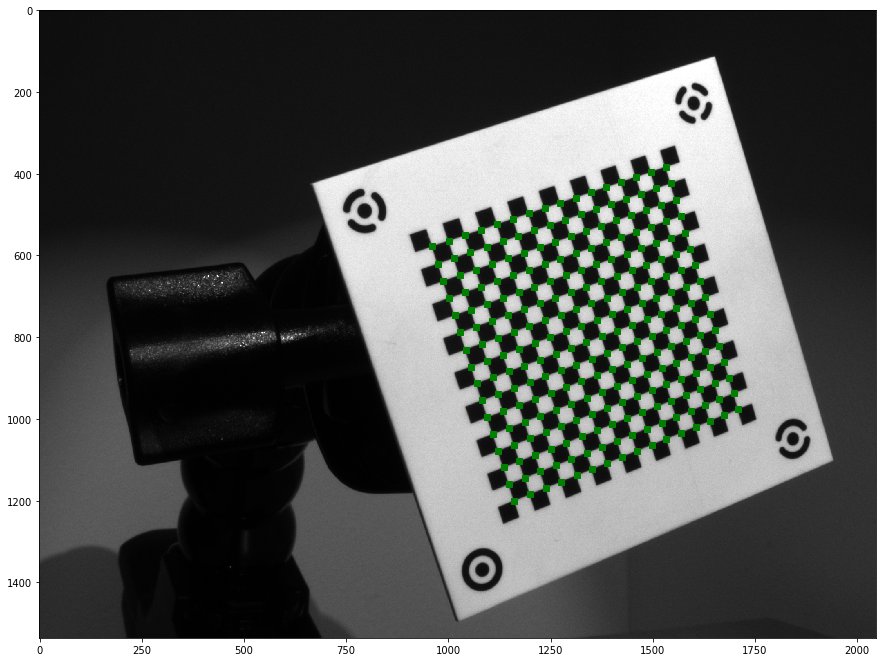

In [21]:
idx=4
plt.figure(figsize=(15,15))
plt.imshow(imgs[idx].array_gs, cmap='gray')
ps_c_p = torch2np(ms_w2p[idx](torch.Tensor(np.c_[cb_geom.ps_c, np.zeros(len(cb_geom.ps_c))])))
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'gs')

# Build

In [17]:
!nbdev_build_lib

Converted calib.ipynb.
Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted coordinate_graph.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted test.ipynb.
Converted utils.ipynb.
